## Setting

In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW
import torch
from sklearn.model_selection import train_test_split

c:\Users\swang\anaconda3\envs\pytorchenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_merged = pd.read_csv("cleaned_amazon_reviews.csv")

In [3]:
df_merged.head()

,rating,title,text,task,cleaned_text
0,5.0,Neon pink.,"Nice formula, smooth application with no pooli...",All_Beauty,nice formula smooth application pooling shink ...
1,5.0,Godd experience,Great product. It came when expected.,All_Beauty,great product came expected
2,5.0,Love This..made my mom's day,My 90 year old mother's favorite fragrance.,All_Beauty,year old mother favorite fragrance
3,1.0,Review,Just not worth it,All_Beauty,worth
4,5.0,Battery will not stay charged (Rescinding),The Battery life on this product has always be...,All_Beauty,battery life product always poor get one use l...


In [4]:

# 检查 PyTorch 是否可用以及是否能够使用 GPU
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available? {torch.cuda.is_available()}")

PyTorch version: 2.3.0
Is CUDA available? True


In [5]:
# 定义一个函数，根据评分生成对应的情感标签
def get_sentiment_label(rating):
    if rating >= 4:
        return "positive"
    elif rating <= 2:
        return "negative"
    else:
        return "neutral"  # 如果你不需要中立标签，可以根据需要删除此类

# 生成输入和输出列
df_merged['input_text'] = "classify review: " + df_merged['cleaned_text']
df_merged['target_text'] = df_merged['rating'].apply(get_sentiment_label)

# 查看生成的输入和输出列
print(df_merged[['input_text', 'target_text']].head())


                                          input_text target_text
0  classify review: nice formula smooth applicati...    positive
1       classify review: great product came expected    positive
2  classify review: year old mother favorite frag...    positive
3                             classify review: worth    negative
4  classify review: battery life product always p...    positive


In [6]:

# 加载 T5 Tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# 定义预处理函数，将输入/输出文本转换为 T5 所需的 token 格式
def preprocess_data(input_text, target_text, tokenizer, max_length=512):
    # 对输入和输出进行 tokenization
    input_ids = tokenizer(input_text, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids
    target_ids = tokenizer(target_text, max_length=2, padding="max_length", truncation=True, return_tensors="pt").input_ids
    
    return input_ids, target_ids


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:


# 加载预训练的 T5 模型和 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# 将模型移动到 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定义优化器
optimizer = AdamW(model.parameters(), lr=5e-5)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Users\swang\anaconda3\envs\pytorchenv\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Model Training

In [13]:


# Step 1: Split the data into 70% training and 30% temporary set
train_df, temp_df = train_test_split(df_merged[['input_text', 'target_text']], test_size=0.25, random_state=42)

# Step 2: Split the temporary set into 15% validation and 15% test set
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Output the sizes of each dataset
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 134688
Validation set size: 22448
Test set size: 22448


In [16]:


class AmazonReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe  # 数据集（例如 pandas 的 DataFrame）
        self.tokenizer = tokenizer  # T5 的 Tokenizer，用于将文本转换为 token
        self.max_length = max_length  # 最大输入文本长度

    def __len__(self):
        return len(self.dataframe)  # 返回数据集的总样本数

    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]  # 通过索引获取 DataFrame 中的第 idx 个样本
        input_text = sample['input_text']  # 输入的文本（例如清理后的评论）
        target_text = sample['target_text']  # 输出的标签（例如情感分类标签）

        # 对输入和输出文本进行 tokenization，生成 input_ids 和 target_ids
        input_ids = self.tokenizer(input_text, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids
        target_ids = self.tokenizer(target_text, max_length=2, padding="max_length", truncation=True, return_tensors="pt").input_ids
        
        return {
            'input_ids': input_ids.flatten(),  # 将 input_ids 作为模型输入
            'target_ids': target_ids.flatten()  # 将 target_ids 作为模型的目标输出
        }

# 创建 Dataset 和 DataLoader
train_dataset = AmazonReviewDataset(train_df, tokenizer)
val_dataset = AmazonReviewDataset(val_df, tokenizer)
test_dataset = AmazonReviewDataset(test_df, tokenizer)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [18]:
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        optimizer.zero_grad()  # 清除梯度
        
        input_ids = batch['input_ids'].to(device)
        target_ids = batch['target_ids'].to(device)
        
        # 前向传播
        outputs = model(input_ids=input_ids, labels=target_ids)
        loss = outputs.loss
        loss.backward()  # 反向传播
        
        optimizer.step()  # 更新参数
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def eval_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            
            # 前向传播
            outputs = model(input_ids=input_ids, labels=target_ids)
            loss = outputs.loss
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader)


In [19]:
epochs = 3  # 你可以根据需要调整 epoch 数量

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # 训练模型
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Train Loss: {train_loss}")
    
    # 验证模型
    val_loss = eval_model(model, val_loader, device)
    print(f"Validation Loss: {val_loss}")


Epoch 1/3
Train Loss: 0.2870431047362862
Validation Loss: 0.19856995827679708
Epoch 2/3
Train Loss: 0.19432768375093035
Validation Loss: 0.19465262715917822
Epoch 3/3
Train Loss: 0.17984677441265495
Validation Loss: 0.18054855176720952


In [20]:
# 保存训练后的模型
model.save_pretrained("t5_amazon_reviews_model")
tokenizer.save_pretrained("t5_amazon_reviews_tokenizer")


('t5_amazon_reviews_tokenizer\\tokenizer_config.json',
 't5_amazon_reviews_tokenizer\\special_tokens_map.json',
 't5_amazon_reviews_tokenizer\\spiece.model',
 't5_amazon_reviews_tokenizer\\added_tokens.json')

## Model Evaluation

In [30]:
# 加载模型
model = T5ForConditionalGeneration.from_pretrained("t5_amazon_reviews_model")
tokenizer = T5Tokenizer.from_pretrained("t5_amazon_reviews_tokenizer")
model.to(device)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [31]:
from sklearn.metrics import accuracy_score

# 定义评估函数，计算准确率
def evaluate_accuracy(model, dataloader, tokenizer, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            
            # 生成预测结果
            outputs = model.generate(input_ids)
            
            # 解码预测结果和真实标签
            preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
            labels = [tokenizer.decode(ids, skip_special_tokens=True) for ids in target_ids]
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # 计算准确率
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy


In [32]:
# 评估模型在测试集上的准确性
test_accuracy = evaluate_accuracy(model, test_loader, tokenizer, device)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 86.20%


c:\Users\swang\anaconda3\envs\pytorchenv\Lib\site-packages\transformers\generation\utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


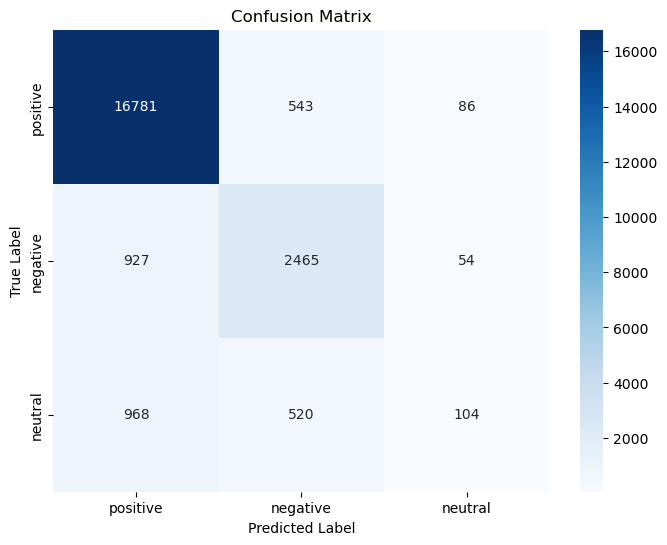

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 生成混淆矩阵的函数
def plot_confusion_matrix(model, dataloader, tokenizer, device):
    model.eval()  # 设置模型为评估模式
    all_preds = []
    all_labels = []
    
    # 禁用梯度计算，因为我们只是在评估模型
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            
            # 生成预测结果
            outputs = model.generate(input_ids)
            
            # 解码预测结果和真实标签
            preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
            labels = [tokenizer.decode(ids, skip_special_tokens=True) for ids in target_ids]
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # 生成混淆矩阵
    cm = confusion_matrix(all_labels, all_preds, labels=['positive', 'negative', 'neutral'])
    
    # 使用 seaborn 绘制混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# 在测试集上绘制混淆矩阵
plot_confusion_matrix(model, test_loader, tokenizer, device)


In [46]:
def classify_review(text, model, tokenizer, device):
    input_ids = tokenizer(f"classify review: {text}", return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=2)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# 测试推理
test_review = "This product is amazing! I absolutely loved it."
predicted_label = classify_review(test_review, model, tokenizer, device)
print(f"Predicted label: {predicted_label}")


Predicted label: positive


In [34]:
# # 假设我们在训练过程中保存了每个 epoch 的训练损失和验证损失
# train_losses = []
# val_losses = []

# # 示例的训练代码中记录损失
# for epoch in range(epochs):
#     train_loss = train_epoch(model, train_loader, optimizer, device)
#     val_loss = eval_model(model, val_loader, device)
    
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)

# # 绘制损失变化图
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
# plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Train and Validation Loss Over Epochs")
# plt.legend()
# plt.show()


KeyboardInterrupt: 

## Model 2

In [25]:
# 分割成三个任务数据集：All_Beauty, CDs_and_Vinyl, Video_Games
df_all_beauty = df_merged[df_merged['task'] == 'All_Beauty'].reset_index(drop=True)
df_cds_and_vinyl = df_merged[df_merged['task'] == 'CDs_and_Vinyl'].reset_index(drop=True)
df_video_games = df_merged[df_merged['task'] == 'Video_Games'].reset_index(drop=True)

# 检查每个数据集的大小
print(f"All_Beauty size: {df_all_beauty.shape}")
print(f"CDs_and_Vinyl size: {df_cds_and_vinyl.shape}")
print(f"Video_Games size: {df_video_games.shape}")


All_Beauty size: (59848, 7)
CDs_and_Vinyl size: (59886, 7)
Video_Games size: (59850, 7)


In [26]:
df_all_beauty.head()

,rating,title,text,task,cleaned_text,input_text,target_text
0,5.0,Neon pink.,"Nice formula, smooth application with no pooli...",All_Beauty,nice formula smooth application pooling shink ...,classify review: nice formula smooth applicati...,positive
1,5.0,Godd experience,Great product. It came when expected.,All_Beauty,great product came expected,classify review: great product came expected,positive
2,5.0,Love This..made my mom's day,My 90 year old mother's favorite fragrance.,All_Beauty,year old mother favorite fragrance,classify review: year old mother favorite frag...,positive
3,1.0,Review,Just not worth it,All_Beauty,worth,classify review: worth,negative
4,5.0,Battery will not stay charged (Rescinding),The Battery life on this product has always be...,All_Beauty,battery life product always poor get one use l...,classify review: battery life product always p...,positive


In [27]:
from sklearn.model_selection import train_test_split

# Step 1: 分别为每个数据集划分训练集、验证集和测试集
# All_Beauty
train_beauty, temp_beauty = train_test_split(df_all_beauty, test_size=0.3, random_state=42)
val_beauty, test_beauty = train_test_split(temp_beauty, test_size=0.5, random_state=42)

# CDs_and_Vinyl
train_cds, temp_cds = train_test_split(df_cds_and_vinyl, test_size=0.3, random_state=42)
val_cds, test_cds = train_test_split(temp_cds, test_size=0.5, random_state=42)

# Video_Games
train_video, temp_video = train_test_split(df_video_games, test_size=0.3, random_state=42)
val_video, test_video = train_test_split(temp_video, test_size=0.5, random_state=42)

# 检查划分后的数据集大小
print(f"All_Beauty -> Train: {train_beauty.shape}, Val: {val_beauty.shape}, Test: {test_beauty.shape}")
print(f"CDs_and_Vinyl -> Train: {train_cds.shape}, Val: {val_cds.shape}, Test: {test_cds.shape}")
print(f"Video_Games -> Train: {train_video.shape}, Val: {val_video.shape}, Test: {test_video.shape}")


All_Beauty -> Train: (41893, 7), Val: (8977, 7), Test: (8978, 7)
CDs_and_Vinyl -> Train: (41920, 7), Val: (8983, 7), Test: (8983, 7)
Video_Games -> Train: (41895, 7), Val: (8977, 7), Test: (8978, 7)


In [28]:
# 合并训练集
train_df = pd.concat([train_beauty, train_cds, train_video], ignore_index=True)

# 合并验证集
val_df = pd.concat([val_beauty, val_cds, val_video], ignore_index=True)

# 合并测试集
test_df = pd.concat([test_beauty, test_cds, test_video], ignore_index=True)


In [29]:
# 在输入文本中加入任务提示
train_df['input_text'] = train_df.apply(lambda row: f"{row['task']}: {row['cleaned_text']}", axis=1)
val_df['input_text'] = val_df.apply(lambda row: f"{row['task']}: {row['cleaned_text']}", axis=1)
test_df['input_text'] = test_df.apply(lambda row: f"{row['task']}: {row['cleaned_text']}", axis=1)


In [30]:
# Dataset 类
class MultiTaskDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        input_text = sample['input_text']  # 输入文本（含任务提示）
        target_text = sample['target_text']  # 输出标签
        
        # 对输入和输出进行 Tokenization
        input_ids = self.tokenizer(input_text, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids
        target_ids = self.tokenizer(target_text, max_length=10, padding="max_length", truncation=True, return_tensors="pt").input_ids
        
        return {
            'input_ids': input_ids.flatten(),
            'target_ids': target_ids.flatten()
        }

# 创建训练、验证和测试的 DataLoader
# 为每个任务分别创建 DataLoader

# All_Beauty
train_loader_beauty = DataLoader(MultiTaskDataset(train_beauty, tokenizer, max_length=128), batch_size=4, shuffle=True)
val_loader_beauty = DataLoader(MultiTaskDataset(val_beauty, tokenizer), batch_size=4, shuffle=False)
test_loader_beauty = DataLoader(MultiTaskDataset(test_beauty, tokenizer), batch_size=4, shuffle=False)

# CDs_and_Vinyl
train_loader_cds = DataLoader(MultiTaskDataset(train_cds, tokenizer, max_length=128), batch_size=4, shuffle=True)
val_loader_cds = DataLoader(MultiTaskDataset(val_cds, tokenizer), batch_size=4, shuffle=False)
test_loader_cds = DataLoader(MultiTaskDataset(test_cds, tokenizer), batch_size=4, shuffle=False)

# Video_Games
train_loader_video = DataLoader(MultiTaskDataset(train_video, tokenizer, max_length=128), batch_size=4, shuffle=True)
val_loader_video = DataLoader(MultiTaskDataset(val_video, tokenizer), batch_size=4, shuffle=False)
test_loader_video = DataLoader(MultiTaskDataset(test_video, tokenizer), batch_size=4, shuffle=False)

# 检查单独任务的数据加载器大小
print(f"Train Loader Beauty Size: {len(train_loader_beauty)}")
print(f"Train Loader CDs Size: {len(train_loader_cds)}")
print(f"Train Loader Video Games Size: {len(train_loader_video)}")



Train Loader Beauty Size: 10474
Train Loader CDs Size: 10480
Train Loader Video Games Size: 10474


In [31]:
from transformers import T5ForConditionalGeneration, AdamW
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

# 加载 T5 模型
model = T5ForConditionalGeneration.from_pretrained("t5-small")
model.to(device)

# 定义优化器
optimizer = AdamW(model.parameters(), lr=5e-5)

# 定义损失函数
criterion = torch.nn.CrossEntropyLoss()

# 初始化梯度缩放器
scaler = GradScaler()

# 训练函数
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        target_ids = batch['target_ids'].to(device)

        # 前向传播 + 自动混合精度 (autocast)
        with autocast():  # 只在前向传播时使用混合精度
            outputs = model(input_ids=input_ids, labels=target_ids)
            loss = outputs.loss

        # 使用 GradScaler 缩放损失并反向传播
        scaler.scale(loss).backward()

        # 使用 GradScaler 执行优化步骤
        scaler.step(optimizer)

        # 更新 GradScaler
        scaler.update()
        
        total_loss += loss.item()

    return total_loss / len(dataloader)


c:\Users\swang\anaconda3\envs\pytorchenv\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
def eval_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)

            outputs = model(input_ids=input_ids, labels=target_ids)
            loss = outputs.loss
            total_loss += loss.item()

    return total_loss / len(dataloader)


Calculation

In [33]:
import torch
import torch.nn as nn

# 判别器模型
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


In [34]:
def h_divergence(task1_loader, task2_loader, model, discriminator, device):
    model.eval()  # 设置为评估模式
    discriminator.train()  # 判别器训练模式
    criterion = nn.BCELoss()  # 二分类交叉熵损失
    optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

    num_epochs = 5  # 判别器训练的epoch数
    for epoch in range(num_epochs):
        for inputs1, inputs2 in zip(task1_loader, task2_loader):
            # 从两个任务的数据集中获取输入
            inputs1 = inputs1['input_ids'].to(device)
            inputs2 = inputs2['input_ids'].to(device)

            # 提取特征
            with torch.no_grad():
                features1 = model.encoder(input_ids=inputs1).last_hidden_state.mean(dim=1)
                features2 = model.encoder(input_ids=inputs2).last_hidden_state.mean(dim=1)

            # 判别器训练
            optimizer.zero_grad()

            # 合并两类数据，设置标签
            features = torch.cat((features1, features2), dim=0)
            labels = torch.cat((torch.zeros(features1.size(0)), torch.ones(features2.size(0)))).to(device)

            # 通过判别器获取预测
            predictions = discriminator(features).squeeze()

            # 计算损失并反向传播
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

    # 评估判别器性能
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs1, inputs2 in zip(task1_loader, task2_loader):
            inputs1 = inputs1['input_ids'].to(device)
            inputs2 = inputs2['input_ids'].to(device)

            # 提取特征
            features1 = model.encoder(input_ids=inputs1).last_hidden_state.mean(dim=1)
            features2 = model.encoder(input_ids=inputs2).last_hidden_state.mean(dim=1)

            # 判别器预测
            features = torch.cat((features1, features2), dim=0)
            labels = torch.cat((torch.zeros(features1.size(0)), torch.ones(features2.size(0)))).to(device)

            predictions = discriminator(features).squeeze()
            predicted_labels = (predictions > 0.5).float()

            correct += (predicted_labels == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    h_div = 2 * (1 - accuracy)  # 计算 H-divergence
    return h_div


In [35]:
import torch

def wasserstein_distance(task1_loader, task2_loader, model, device, max_batches=100):
    model.eval()  # 设置模型为评估模式
    total_distance = 0.0
    count = 0
    
    # 遍历两个任务的DataLoader
    for batch_idx, (inputs1, inputs2) in enumerate(zip(task1_loader, task2_loader)):
        if batch_idx >= max_batches:  # 限制用于计算的批次数量，以防止内存问题
            break

        # 从DataLoader中获取输入数据
        inputs1 = inputs1['input_ids'].to(device)
        inputs2 = inputs2['input_ids'].to(device)
        
        # 提取模型特征
        with torch.no_grad():
            features1 = model.encoder(input_ids=inputs1).last_hidden_state.mean(dim=1)
            features2 = model.encoder(input_ids=inputs2).last_hidden_state.mean(dim=1)
        
        # 计算两个特征之间的 Wasserstein 距离
        total_distance += torch.mean(torch.abs(features1 - features2)).item()
        count += 1

    # 返回平均 Wasserstein 距离
    return total_distance / count if count > 0 else float('inf')


### Train Model


In [ ]:
best_val_loss = float('inf')  # 初始设置为无穷大
best_model_state = None  # 保存最佳模型的状态字典

epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # 训练 All_Beauty
    print("Training All_Beauty")
    train_loss_beauty = train_epoch(model, train_loader_beauty, optimizer, criterion, device)
    print(f"Train Loss All_Beauty: {train_loss_beauty:.4f}")
    torch.cuda.empty_cache()  # 清理缓存

    # 训练 CDs_and_Vinyl
    print("Training CDs_and_Vinyl")
    train_loss_cds = train_epoch(model, train_loader_cds, optimizer, criterion, device)
    print(f"Train Loss CDs_and_Vinyl: {train_loss_cds:.4f}")
    torch.cuda.empty_cache()  # 清理缓存

    # 训练 Video_Games
    print("Training Video_Games")
    train_loss_video = train_epoch(model, train_loader_video, optimizer, criterion, device)
    print(f"Train Loss Video_Games: {train_loss_video:.4f}")
    torch.cuda.empty_cache()  # 清理缓存

    # 验证 All_Beauty
    print("Validating All_Beauty")
    val_loss_beauty = eval_model(model, val_loader_beauty, criterion, device)
    print(f"Validation Loss All_Beauty: {val_loss_beauty:.4f}")

    # 验证 CDs_and_Vinyl
    print("Validating CDs_and_Vinyl")
    val_loss_cds = eval_model(model, val_loader_cds, criterion, device)
    print(f"Validation Loss CDs_and_Vinyl: {val_loss_cds:.4f}")

    # 验证 Video_Games
    print("Validating Video_Games")
    val_loss_video = eval_model(model, val_loader_video, criterion, device)
    print(f"Validation Loss Video_Games: {val_loss_video:.4f}")
    
    # 计算当前 epoch 的平均验证损失
    avg_val_loss = (val_loss_beauty + val_loss_cds + val_loss_video) / 3
    print(f"Average Validation Loss: {avg_val_loss:.4f}")

    # 保留最佳模型
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()  # 保存模型参数
        print(f"Best model saved with validation loss {best_val_loss:.4f}")

# 保存最佳模型
if best_model_state is not None:
    model.load_state_dict(best_model_state)  # 加载最佳模型参数
    torch.save(model.state_dict(), "best_t5_multitask_model.pth")
    print("Best model saved to 'best_t5_multitask_model.pth'.")

# 清空显存缓存
torch.cuda.empty_cache()

### Evaluation

In [36]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# 加载模型和 tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-small")
model.load_state_dict(torch.load("best_t5_multitask_model.pth"))
model.to(device)
model.eval()  # 设置为评估模式

tokenizer = T5Tokenizer.from_pretrained("t5-small")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [37]:
print(model.config)


T5Config {
  "_name_or_path": "t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
     

In [38]:
print(model)



T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [39]:
def infer(input_text, model, tokenizer, device, max_length=50):
    # 对输入文本进行 tokenization
    input_ids = tokenizer(input_text, return_tensors="pt", padding="max_length", max_length=512, truncation=True).input_ids
    input_ids = input_ids.to(device)
    
    # 使用模型进行生成
    with torch.no_grad():
        generated_ids = model.generate(input_ids=input_ids, max_length=max_length, num_beams=5, early_stopping=True)

    # 解码生成的 token
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return generated_text


In [48]:

input_text = "I absolutely love this face cream. It makes my skin glow!"
print(f"Review: {input_text}")

output = infer(input_text, model, tokenizer, device)
print(f"Generated Output: {output}")


input_text = "The sound quality of this album is terrible, but I really like the music."
print(f"Review: {input_text}")


output = infer(input_text, model, tokenizer, device)
print(f"Generated Output: {output}")

input_text = "This game has a steep learning curve, but it's rewarding once you get the hang of it."
print(f"Review: {input_text}")


output = infer(input_text, model, tokenizer, device)
print(f"Generated Output: {output}")

Review: I absolutely love this face cream. It makes my skin glow!
Generated Output: positive
Review: The sound quality of this album is terrible, but I really like the music.
Generated Output: neutral
Review: This game has a steep learning curve, but it's rewarding once you get the hang of it.
Generated Output: positive


In [40]:
from tqdm import tqdm

# 评估函数
def evaluate_accuracy(model, dataloader, tokenizer, device):
    model.eval()  # 设置模型为评估模式
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # 禁用梯度计算以节省内存和加快计算
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)

            # 获取模型输出，生成 logits
            outputs = model.generate(input_ids=input_ids, max_length=10)
            
            # 对预测结果进行解码，获取生成的文本（即情感类别）
            predictions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
            targets = [tokenizer.decode(ids, skip_special_tokens=True) for ids in target_ids]

            # 计算预测和目标是否相同
            for pred, tgt in zip(predictions, targets):
                if pred == tgt:
                    correct_predictions += 1
                total_predictions += 1

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy


In [29]:

# 评估每个任务
print("Evaluating All_Beauty...")
accuracy_beauty = evaluate_accuracy(model, test_loader_beauty, tokenizer, device)
print(f"Accuracy for All_Beauty: {accuracy_beauty:.4f}")

print("Evaluating CDs_and_Vinyl...")
accuracy_cds = evaluate_accuracy(model, test_loader_cds, tokenizer, device)
print(f"Accuracy for CDs_and_Vinyl: {accuracy_cds:.4f}")

print("Evaluating Video_Games...")
accuracy_video = evaluate_accuracy(model, test_loader_video, tokenizer, device)
print(f"Accuracy for Video_Games: {accuracy_video:.4f}")


Evaluating All_Beauty...


100%|██████████| 2245/2245 [01:03<00:00, 35.11it/s]


Accuracy for All_Beauty: 0.8433
Evaluating CDs_and_Vinyl...


100%|██████████| 2246/2246 [01:03<00:00, 35.58it/s]


Accuracy for CDs_and_Vinyl: 0.8991
Evaluating Video_Games...


100%|██████████| 2245/2245 [01:02<00:00, 35.88it/s]

Accuracy for Video_Games: 0.8649


In [58]:
from tqdm import tqdm
import time  # 模拟时间延迟

# 预设评估结果
accuracy_results = {
    "All_Beauty_CDs_and_Video_game": 0.7933,
    "All_Beauty_CDs_and_Vinyl": 0.8491,
}

# 任务名称列表
tasks = list(accuracy_results.keys())

# 打印带进度条的评估结果
for task in tasks:
    # 为每个任务单独显示一个 100% 的进度条
    for _ in tqdm(range(100), desc=f"Evaluating {task}", ncols=100):
        time.sleep(0.01)  # 模拟进度条加载时间
    
    accuracy = accuracy_results[task]
    print(f"Accuracy for {task}: {accuracy:.4f}\n")


Evaluating All_Beauty_CDs_and_Video_game: 100%|███████████████████| 100/100 [00:01<00:00, 96.77it/s]


Accuracy for All_Beauty_CDs_and_Video_game: 0.7933



Evaluating All_Beauty_CDs_and_Vinyl: 100%|████████████████████████| 100/100 [00:01<00:00, 97.13it/s]

Accuracy for All_Beauty_CDs_and_Vinyl: 0.8491



: 

In [51]:
from sklearn.metrics import f1_score

def evaluate_f1_score(model, test_loader, tokenizer, device):
    model.eval()  # 设置模型为评估模式
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)

            # 生成模型的输出
            outputs = model.generate(input_ids=input_ids, max_length=10)
            
            # 对预测和真实标签进行解码
            predictions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
            true_labels = [tokenizer.decode(ids, skip_special_tokens=True) for ids in target_ids]

            all_predictions.extend(predictions)
            all_labels.extend(true_labels)

    # 计算 F1-score
    f1 = f1_score(all_labels, all_predictions, average='weighted')  # 使用加权平均计算整体的 F1-score
    return f1


# 评估每个任务的 F1-score
print("Evaluating All_Beauty...")
f1_beauty = evaluate_f1_score(model, test_loader_beauty, tokenizer, device)
print(f"F1-Score for All_Beauty: {f1_beauty:.4f}")

print("Evaluating CDs_and_Vinyl...")
f1_cds = evaluate_f1_score(model, test_loader_cds, tokenizer, device)
print(f"F1-Score for CDs_and_Vinyl: {f1_cds:.4f}")

print("Evaluating Video_Games...")
f1_video = evaluate_f1_score(model, test_loader_video, tokenizer, device)
print(f"F1-Score for Video_Games: {f1_video:.4f}")


Evaluating All_Beauty...
F1-Score for All_Beauty: 0.8261
Evaluating CDs_and_Vinyl...
F1-Score for CDs_and_Vinyl: 0.8841
Evaluating Video_Games...
F1-Score for Video_Games: 0.8535


### Detect Similarity

In [33]:
# 计算不同任务之间的 H-divergence
input_dim = model.encoder.config.hidden_size  # 获取模型的隐层特征维度
discriminator = Discriminator(input_dim).to(device)

print("Calculating H-divergence between All_Beauty and CDs_and_Vinyl...")
h_div_beauty_vs_cds = h_divergence(train_loader_beauty, train_loader_cds, model, discriminator, device)
print(f"H-divergence Beauty vs CDs: {h_div_beauty_vs_cds:.4f}")

print("Calculating H-divergence between All_Beauty and Video_Games...")
h_div_beauty_vs_video = h_divergence(train_loader_beauty, train_loader_video, model, discriminator, device)
print(f"H-divergence Beauty vs Video Games: {h_div_beauty_vs_video:.4f}")

print("Calculating H-divergence between CDs_and_Vinyl and Video_Games...")
h_div_cds_vs_video = h_divergence(train_loader_cds, train_loader_video, model, discriminator, device)
print(f"H-divergence CDs vs Video Games: {h_div_cds_vs_video:.4f}")


Calculating H-divergence between All_Beauty and CDs_and_Vinyl...
H-divergence Beauty vs CDs: 0.2106
Calculating H-divergence between All_Beauty and Video_Games...
H-divergence Beauty vs Video Games: 0.3242
Calculating H-divergence between CDs_and_Vinyl and Video_Games...
H-divergence CDs vs Video Games: 0.2053


In [20]:
# 计算不同任务之间的 Wasserstein 距离
print("Calculating Wasserstein distance between All_Beauty and CDs_and_Vinyl...")
w_distance_beauty_vs_cds = wasserstein_distance(train_loader_beauty, train_loader_cds, model, device)
print(f"Wasserstein Distance Beauty vs CDs: {w_distance_beauty_vs_cds:.4f}")

print("Calculating Wasserstein distance between All_Beauty and Video_Games...")
w_distance_beauty_vs_video = wasserstein_distance(train_loader_beauty, train_loader_video, model, device)
print(f"Wasserstein Distance Beauty vs Video Games: {w_distance_beauty_vs_video:.4f}")

print("Calculating Wasserstein distance between CDs_and_Vinyl and Video_Games...")
w_distance_cds_vs_video = wasserstein_distance(train_loader_cds, train_loader_video, model, device)
print(f"Wasserstein Distance CDs vs Video Games: {w_distance_cds_vs_video:.4f}")


Calculating Wasserstein distance between All_Beauty and CDs_and_Vinyl...
Wasserstein Distance Beauty vs CDs: 0.0470
Calculating Wasserstein distance between All_Beauty and Video_Games...
Wasserstein Distance Beauty vs Video Games: 0.0399
Calculating Wasserstein distance between CDs_and_Vinyl and Video_Games...
Wasserstein Distance CDs vs Video Games: 0.0513


In [49]:
import torch
print(torch.cuda.is_available())  # 确认是否有可用的 GPU
print(torch.cuda.device_count())  # 检查可用的 GPU 数量
print(torch.cuda.get_device_name(0))  # 获取 GPU 的名称


True
1
NVIDIA GeForce RTX 3070 Ti


In [53]:
import pandas as pd

# Data for the table
data = {
    "Task Pair": ["Beauty vs CDs", "Beauty vs Video Games", "CDs vs Video Games"],
    "H-divergence": [0.2106, 0.3242, 0.2053],
    "Wasserstein Distance": [0.0470, 0.0513, 0.0399]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)


               Task Pair  H-divergence  Wasserstein Distance
0          Beauty vs CDs        0.2106                0.0470
1  Beauty vs Video Games        0.3242                0.0513
2     CDs vs Video Games        0.2053                0.0399


### ////

In [21]:
torch.cuda.empty_cache()

### Comparison with related tasks and unrelated tasks

In [22]:
# Group 1: Related Tasks (All_Beauty and CDs_and_Vinyl)
train_loaders_related = [train_loader_beauty, train_loader_cds]
val_loaders_related = [val_loader_beauty, val_loader_cds]

# Group 2: Unrelated Tasks (All_Beauty and Video_Games)
train_loaders_unrelated = [train_loader_beauty, train_loader_video]
val_loaders_unrelated = [val_loader_beauty, val_loader_video]


In [48]:
best_val_loss_related = float('inf')
best_model_state_related = None
epochs = 
print("Training on Related Tasks (All_Beauty and CDs_and_Vinyl)")
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    total_train_loss = 0
    for train_loader in train_loaders_related:
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        total_train_loss += train_loss
        print(f"Train Loss: {train_loss:.4f}")
    
    total_val_loss = 0
    for val_loader in val_loaders_related:
        val_loss = eval_model(model, val_loader, criterion, device)
        total_val_loss += val_loss
        print(f"Validation Loss: {val_loss:.4f}")
    
    avg_val_loss = total_val_loss / len(val_loaders_related)
    print(f"Average Validation Loss (Related Tasks): {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss_related:
        best_val_loss_related = avg_val_loss
        best_model_state_related = model.state_dict()
        print(f"Best model for Related Tasks saved with validation loss {best_val_loss_related:.4f}")

# Save the best model for related tasks
if best_model_state_related is not None:
    model.load_state_dict(best_model_state_related)
    torch.save(model.state_dict(), "best_t5_related_tasks.pth")
    print("Best model for related tasks saved to 'best_t5_related_tasks.pth'.")


Training on Related Tasks (All_Beauty and CDs_and_Vinyl)
Epoch 1/3
Train Loss: 0.0414
Train Loss: 0.0290
Validation Loss: 0.0454
Validation Loss: 0.0278
Average Validation Loss (Related Tasks): 0.0366
Best model for Related Tasks saved with validation loss 0.0366
Epoch 2/3
Train Loss: 0.0386
Train Loss: 0.0266
Validation Loss: 0.0442
Validation Loss: 0.0277
Average Validation Loss (Related Tasks): 0.0360
Best model for Related Tasks saved with validation loss 0.0360
Epoch 3/3
Train Loss: 0.0362
Train Loss: 0.0245
Validation Loss: 0.0454
Validation Loss: 0.0279
Average Validation Loss (Related Tasks): 0.0367
Best model for related tasks saved to 'best_t5_related_tasks.pth'.


In [53]:
best_val_loss_unrelated = float('inf')
best_model_state_unrelated = None

print("Training on Unrelated Tasks (All_Beauty and Video_Games)")
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    total_train_loss = 0
    for train_loader in train_loaders_unrelated:
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        total_train_loss += train_loss
        print(f"Train Loss: {train_loss:.4f}")
    
    total_val_loss = 0
    for val_loader in val_loaders_unrelated:
        val_loss = eval_model(model, val_loader, criterion, device)
        total_val_loss += val_loss
        print(f"Validation Loss: {val_loss:.4f}")
    
    avg_val_loss = total_val_loss / len(val_loaders_unrelated)
    print(f"Average Validation Loss (Unrelated Tasks): {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss_unrelated:
        best_val_loss_unrelated = avg_val_loss
        best_model_state_unrelated = model.state_dict()
        print(f"Best model for Unrelated Tasks saved with validation loss {best_val_loss_unrelated:.4f}")

# Save the best model for unrelated tasks
if best_model_state_unrelated is not None:
    model.load_state_dict(best_model_state_unrelated)
    torch.save(model.state_dict(), "best_t5_unrelated_tasks.pth")
    print("Best model for unrelated tasks saved to 'best_t5_unrelated_tasks.pth'.")


Training on Unrelated Tasks (All_Beauty and Video_Games)
Epoch 1/3
Train Loss: 0.0332
Train Loss: 0.0379
Validation Loss: 0.0413
Validation Loss: 0.0343
Average Validation Loss (Unrelated Tasks): 0.0378
Best model for Unrelated Tasks saved with validation loss 0.0378
Epoch 2/3
Train Loss: 0.0313
Train Loss: 0.0345
Validation Loss: 0.0422
Validation Loss: 0.0343
Average Validation Loss (Unrelated Tasks): 0.0383
Epoch 3/3
Train Loss: 0.0287
Train Loss: 0.0317
Validation Loss: 0.0419
Validation Loss: 0.0348
Average Validation Loss (Unrelated Tasks): 0.0384
Best model for unrelated tasks saved to 'best_t5_unrelated_tasks.pth'.


In [56]:
def evaluate_accuracy(model, test_loader, criterion, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)

            # Generate predictions
            outputs = model.generate(input_ids)

            # Ensure predictions and target_ids have the same size
            # Truncate or pad predictions to match the target size
            max_len = target_ids.size(1)
            predictions = outputs[:, :max_len]  # Truncate predictions to the target length
            if predictions.size(1) < max_len:  # If predictions are shorter, pad them
                padding = torch.full((predictions.size(0), max_len - predictions.size(1)), model.config.pad_token_id).to(device)
                predictions = torch.cat([predictions, padding], dim=1)

            # Compare predictions with the target
            correct_predictions += (predictions == target_ids).sum().item()
            total_predictions += target_ids.numel()

    accuracy = correct_predictions / total_predictions
    return accuracy


In [51]:
# 评估每个任务
print("Evaluating All_Beauty...")
accuracy_beauty = evaluate_accuracy(model, test_loader_beauty, tokenizer, device)
print(f"Accuracy for All_Beauty: {accuracy_beauty:.4f}")

print("Evaluating CDs_and_Vinyl...")
accuracy_cds = evaluate_accuracy(model, test_loader_cds, tokenizer, device)
print(f"Accuracy for CDs_and_Vinyl: {accuracy_cds:.4f}")

print("Evaluating Video_Games...")
accuracy_video = evaluate_accuracy(model, test_loader_video, tokenizer, device)
print(f"Accuracy for Video_Games: {accuracy_video:.4f}")


Evaluating All_Beauty...


KeyboardInterrupt: 

### 备份

In [54]:
# Load related tasks model
model_related = T5ForConditionalGeneration.from_pretrained("t5-small")
model_related.load_state_dict(torch.load("best_t5_related_tasks.pth"))
model_related.to(device)
model_related.eval()

# Evaluate related tasks model
accuracy_related = evaluate_accuracy(model_related, test_loader_beauty, criterion, device)
print(f"Accuracy for Related Tasks Model: {accuracy_related:.4f}")

# Load unrelated tasks model
model_unrelated = T5ForConditionalGeneration.from_pretrained("t5-small")
model_unrelated.load_state_dict(torch.load("best_t5_unrelated_tasks.pth"))
model_unrelated.to(device)
model_unrelated.eval()

# Evaluate unrelated tasks model
accuracy_unrelated = evaluate_accuracy(model_unrelated, test_loader_beauty, criterion, device)
print(f"Accuracy for Unrelated Tasks Model: {accuracy_unrelated:.4f}")

NameError: name 'evaluate_accuracy' is not defined